In [2]:
import pandas as pd

data = pd.read_csv('fmnist_train.csv')
na_values = data.isna().sum().sum()
na_values

424

In [3]:
na_columns = data.isna().sum()
na_columns_with_values = na_columns[na_columns > 0]
na_columns_with_values

pixel361    1
pixel362    1
pixel363    1
pixel364    1
pixel365    1
           ..
pixel780    1
pixel781    1
pixel782    1
pixel783    1
pixel784    1
Length: 424, dtype: int64

In [4]:
data = data.fillna(0)

na_values_after_filling = data.isna().sum().sum()
na_values_after_filling

0

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

labels = data['label'].values
images = data.drop(columns=['label', 'Id']).values

images = images / 255.0
images = images.reshape(-1, 1, 28, 28)

labels_np = np.array(labels)
images_np = np.array(images)

X_train, X_val, y_train, y_val = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((13632, 1, 28, 28), (3408, 1, 28, 28), (13632,), (3408,))

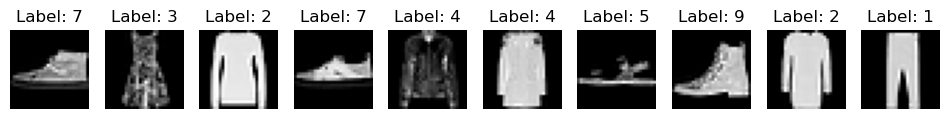

In [6]:
import matplotlib.pyplot as plt

def plot_images(images, labels, n=10):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, n=10)

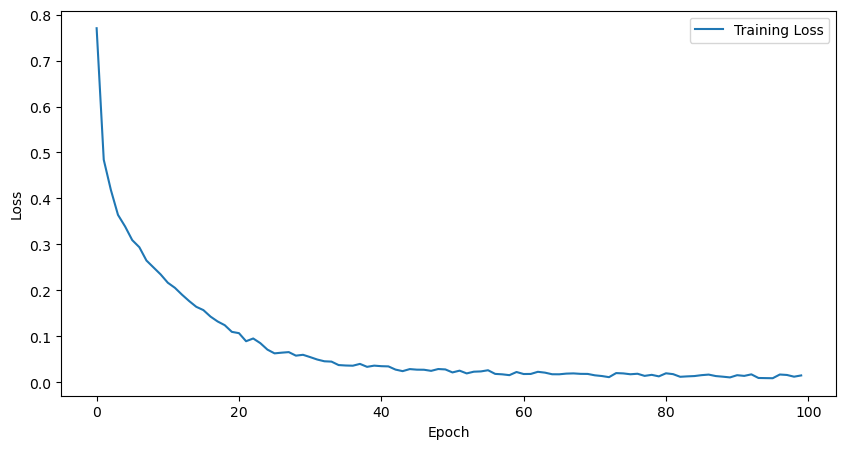

Validation Accuracy: 0.9040


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

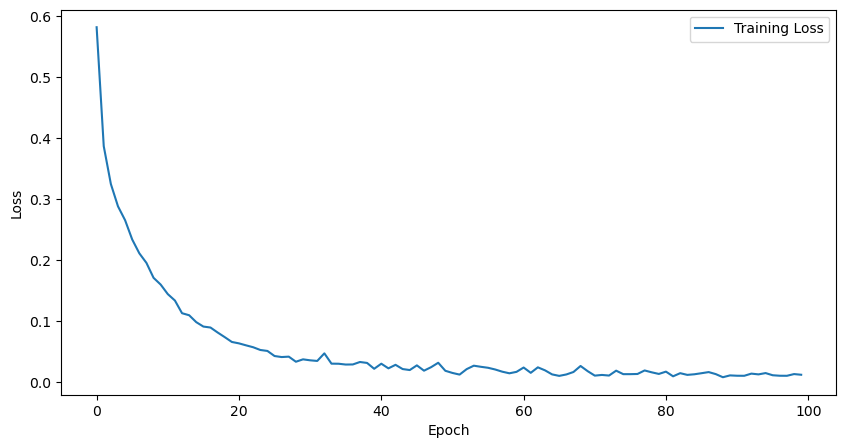

Validation Accuracy: 0.8967


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

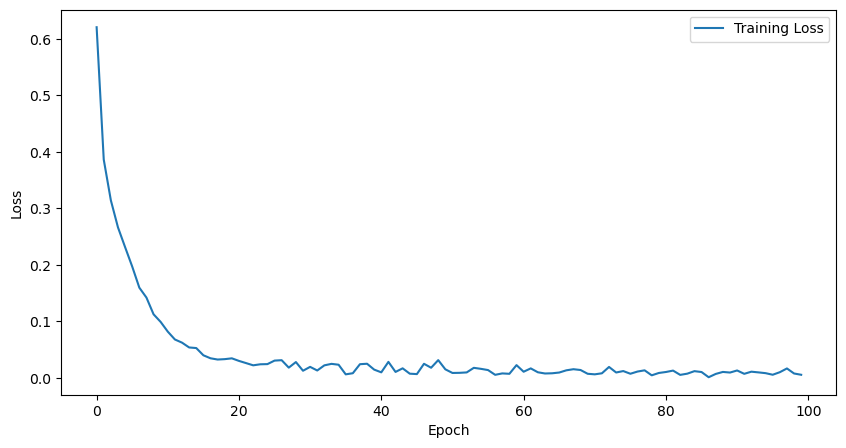

Validation Accuracy: 0.9052


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

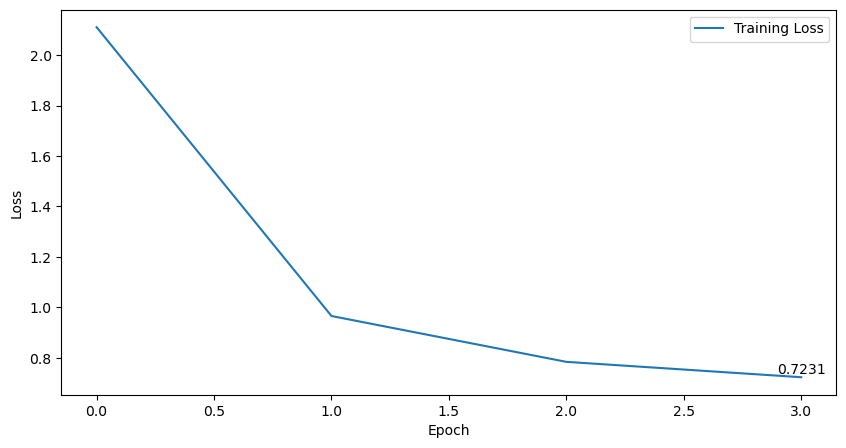

KeyboardInterrupt: 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# аугментация данных
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().transpose((1, 2, 0))  # преобразование для ToPILImage
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(X_train_tensor.repeat(1, 3, 1, 1), y_train_tensor, transform=train_transforms)
val_dataset = CustomDataset(X_val_tensor.repeat(1, 3, 1, 1), y_val_tensor, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class ResNetTransfer(nn.Module):
    def __init__(self):
        super(ResNetTransfer, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNetTransfer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.text(len(train_losses) - 1, train_losses[-1], f"{train_losses[-1]:.4f}", ha="center", va="bottom")
        
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

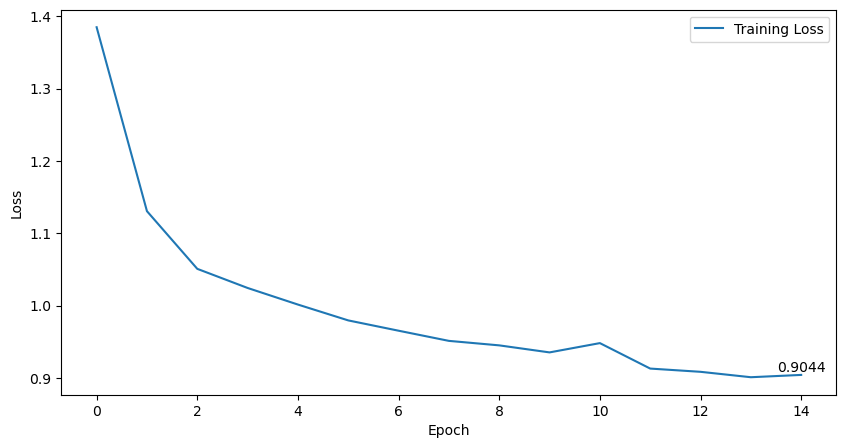

KeyboardInterrupt: 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().transpose((1, 2, 0))  # преобразование для ToPILImage
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(X_train_tensor.repeat(1, 3, 1, 1), y_train_tensor, transform=train_transforms)
val_dataset = CustomDataset(X_val_tensor.repeat(1, 3, 1, 1), y_val_tensor, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class ResNetTransfer(nn.Module):
    def __init__(self):
        super(ResNetTransfer, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Заморозка начальных слоев
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNetTransfer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.text(len(train_losses) - 1, train_losses[-1], f"{train_losses[-1]:.4f}", ha="center", va="bottom")
        
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

In [36]:
import torch
import os

def load_model(model, optimizer, load_path='model_checkpoint.pth'):
    if os.path.exists(load_path):
        checkpoint = torch.load(load_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        print(f'Model loaded, starting from epoch {start_epoch} with loss {loss:.4f}')
        return start_epoch
    else:
        print('No checkpoint found, starting from scratch')
        return 0

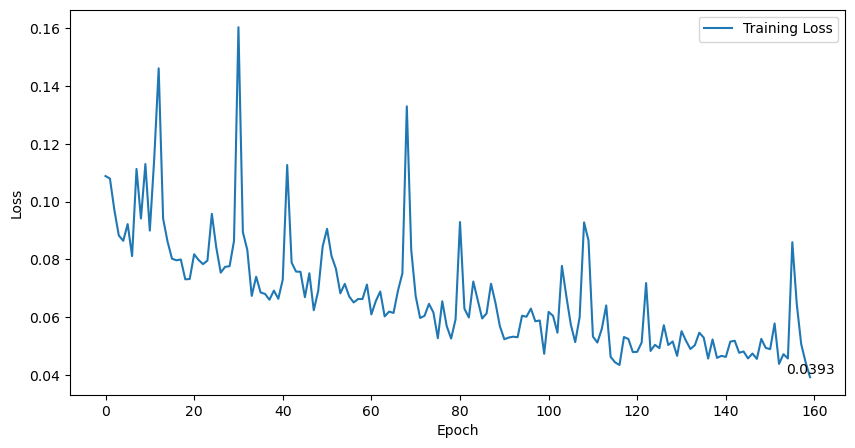

Validation Accuracy: 0.9190


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().transpose((1, 2, 0))  # преобразование для ToPILImage
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(X_train_tensor.repeat(1, 3, 1, 1), y_train_tensor, transform=train_transforms)
val_dataset = CustomDataset(X_val_tensor.repeat(1, 3, 1, 1), y_val_tensor, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class EfficientNetTransfer(nn.Module):
    def __init__(self):
        super(EfficientNetTransfer, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 10)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

model = EfficientNetTransfer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20, save_path='model_checkpoint_2.pth'):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, save_path)
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.text(len(train_losses) - 1, train_losses[-1], f"{train_losses[-1]:.4f}", ha="center", va="bottom")
        
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

start_epoch = load_model(model, optimizer, 'model_checkpoint_180.pth')
end_epoch = 220
train_model(model, train_loader, criterion, optimizer, device, num_epochs=end_epoch - start_epoch, save_path=f'model_checkpoint_{end_epoch}.pth')

evaluate_model(model, val_loader, device)

In [24]:
import torch

save_path = 'trained_model_checkpoint_final.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)

print(f'Model and optimizer state have been saved to {save_path}')

Model and optimizer state have been saved to trained_model_checkpoint.pth


In [43]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

test_data_path = 'fmnist_test.csv'
test_data = pd.read_csv(test_data_path)

test_images = test_data.drop(columns=['Id']).values
test_images = test_images / 255.0  # Нормализация
test_images = test_images.reshape(-1, 1, 28, 28)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).repeat(1, 3, 1, 1)  # Повторение канала до 3

val_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomTestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

test_dataset = CustomTestDataset(test_images_tensor, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model_path = 'model_checkpoint_200.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'Id': test_data['Id'], 'Label': predictions})
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f'Submission file saved to {submission_path}')


C:\Users\muzykantov\AppData\Local\Temp\ipykernel_14924\1388785983.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),


Submission file saved to submission.csv


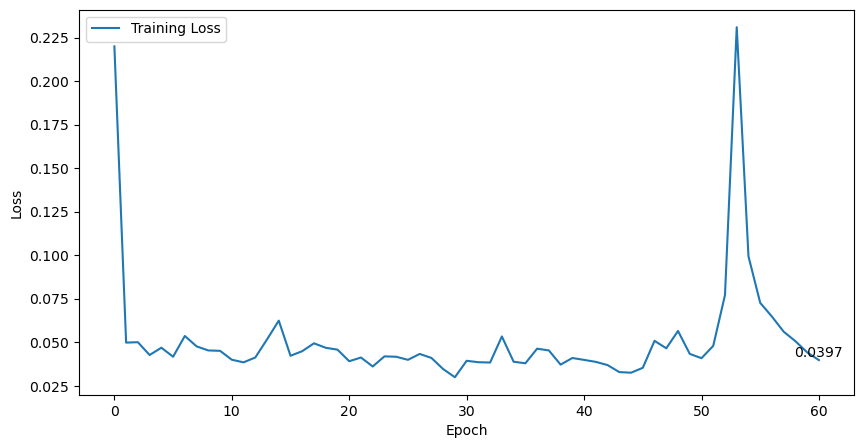

Validation Accuracy: 0.9158


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = self.images[idx].numpy().transpose((1, 2, 0))  # преобразование для ToPILImage
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            raise

train_dataset = CustomDataset(X_train_tensor.repeat(1, 3, 1, 1), y_train_tensor, transform=train_transforms)
val_dataset = CustomDataset(X_val_tensor.repeat(1, 3, 1, 1), y_val_tensor, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

class EfficientNetTransfer(nn.Module):
    def __init__(self):
        super(EfficientNetTransfer, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential()  # оригинальный классификатор
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.classifier(x)
        return x

model = EfficientNetTransfer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler = GradScaler()

def load_checkpoint(filepath, model):
    checkpoint = torch.load(filepath)
    model_dict = model.state_dict()
    
    pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k in model_dict}
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return epoch, loss

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20, save_path='model_checkpoint_2.pth'):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, save_path)
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.text(len(train_losses) - 1, train_losses[-1], f"{train_losses[-1]:.4f}", ha="center", va="bottom")
        
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

start_epoch, _ = load_checkpoint('model_checkpoint_180.pth', model)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # Переинициализация оптимизатора
end_epoch = 220

train_model(model, train_loader, criterion, optimizer, device, num_epochs=end_epoch - start_epoch, save_path=f'model_checkpoint_{end_epoch}.pth')

evaluate_model(model, val_loader, device)

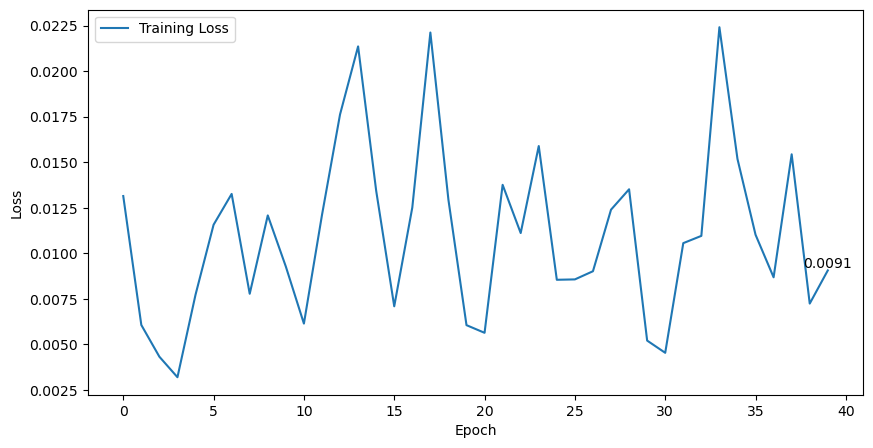

Validation Accuracy: 0.9193


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import models, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().transpose((1, 2, 0))  # преобразование для ToPILImage
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomDataset(X_train_tensor.repeat(1, 3, 1, 1), y_train_tensor, transform=transform)
val_dataset = CustomDataset(X_val_tensor.repeat(1, 3, 1, 1), y_val_tensor, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class EfficientNetTransfer(nn.Module):
    def __init__(self):
        super(EfficientNetTransfer, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, 10)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

model = EfficientNetTransfer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20, save_path='model_checkpoint_2.pth'):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, save_path)
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.text(len(train_losses) - 1, train_losses[-1], f"{train_losses[-1]:.4f}", ha="center", va="bottom")
        
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

start_epoch = load_model(model, optimizer, 'model_checkpoint_180.pth')
end_epoch = 200
train_model(model, train_loader, criterion, optimizer, device, num_epochs=end_epoch - start_epoch, save_path=f'model_checkpoint_{end_epoch}.pth')

evaluate_model(model, val_loader, device)


-----

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [4]:
train_raw = pd.read_csv('C:/Users/muzykantov/Documents/DNN/data/fashion-mnist-testn/fmnist_train.csv', sep=",")
test_raw = pd.read_csv('C:/Users/muzykantov/Documents/DNN/data/fashion-mnist-testn/fmnist_test.csv', sep=',')

In [5]:
train_raw.fillna(0, inplace=True)

In [6]:
train_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [7]:
test_raw.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [8]:
train_raw['split'] = np.random.randn(train_raw.shape[0], 1)
msk = np.random.rand(len(train_raw)) <= 0.7
train = train_raw[msk]
test = train_raw[~msk]

train = train.drop(columns='split')
test = test.drop(columns='split')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,4,0,0,0,5,4,5,5,3,5,...,8.0,7.0,4.0,3.0,7.0,5.0,0.0,0.0,0.0,5


In [9]:
X_train = train.drop(['label'], axis=1)
y_train = train.label

In [10]:
X_test = test.drop(['label'], axis=1)
y_test = test.label

In [11]:
clf = MLPClassifier(max_iter=10, random_state=0)
clf.fit(X_train, y_train)

c:\Users\muzykantov\miniconda3\envs\torchenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=10, random_state=0)

In [12]:
accuracy_score(y_test, clf.predict(X_test))

0.7920945553187366

In [13]:
submission = clf.predict(test_raw)

In [15]:
sample_submission = pd.read_csv('C:/Users/muzykantov/Documents/DNN/data/fashion-mnist-testn/sample_submission.csv')
sample_submission.head()

,Id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [16]:
sample_submission['label'] = submission
sample_submission.to_csv('first_submission.csv', index=False)
sample_submission.head(10)

,Id,label
0,0,0
1,1,1
2,2,2
3,3,0
4,4,1
5,5,6
6,6,8
7,7,4
8,8,5
9,9,0
